In [ ]:
import tensorflow as tf

print(tf.__version__)

2.14.0


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Input
from keras import models
from keras import layers
from keras import optimizers
import random
from keras.preprocessing.image import ImageDataGenerator
from random import randrange
import cv2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.layers import Activation, Flatten, Dropout, BatchNormalization

# K.tensorflow_backend._get_available_gpus()

# 경로 설정(본인의)
train_image_path_temp = 'C:/data_warehouse/Project/data/Training/images/' #**
# train_label_path = '/content/drive/MyDrive/Project/data/Training/labels.json'
# train_image_path_temp = '/content/drive/MyDrive/Project/data/Training/images_temp/'

test_image_path_temp = 'C:/data_warehouse/Project/data/Validation/images/' #**
# test_label_path = '/content/drive/MyDrive/Project/data/Validation/'
# test_image_path_temp = '/content/drive/MyDrive/Project/data/Validation/images_temp/'


In [2]:
import json
# json_file_list = os.listdir(train_label_path)
# print(json_file_list[0])

# 훈련용 라벨데이터 불러오기
with open('C:/data_warehouse/Project/data/Training/labels/labels.json') as f:
    tjs = json.loads(f.read())

tdata = pd.DataFrame(tjs)

# 테스트용 라벨데이터 불러오기
with open('C:/data_warehouse/Project/data/Validation/labels/labels.json') as f:
    vjs = json.loads(f.read())

vdata = pd.DataFrame(vjs)

# 훈련용 라벨데이터(체크용 : 원핫X) 불러오기
with open('C:/data_warehouse/Project/data/Training/labels/labels_for_check.json', encoding='utf-8-sig') as f:
    tjs_fc = json.loads(f.read())

tdata_fc = pd.DataFrame(tjs_fc)

# 테스트용 라벨데이터(체크용 : 원핫X) 불러오기
with open('C:/data_warehouse/Project/data/Validation/labels/labels_for_check.json', encoding='utf-8-sig') as f:
    vjs_fc = json.loads(f.read())

vdata_fc = pd.DataFrame(vjs_fc)

In [3]:
tdata.head()

,ful_path,imgName,man,woman,ivy,feminine,classic,mods,minimal,popart,...,res_by_40s_old,res_by_50s_old,res_by_housewife_job,res_by_special_job,res_by_survice_job,res_by_whitecollar_job,res_by_student_job,res_by_etc_job,res_by_single,res_by_married
0,/content/drive/MyDrive/Project/data/Training/i...,T_00001_50_ivy_M.jpg,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,/content/drive/MyDrive/Project/data/Training/i...,T_00001_50_ivy_M.jpg,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,/content/drive/MyDrive/Project/data/Training/i...,T_00001_50_ivy_M.jpg,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,/content/drive/MyDrive/Project/data/Training/i...,T_00001_50_ivy_M.jpg,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,/content/drive/MyDrive/Project/data/Training/i...,T_00001_50_ivy_M.jpg,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [4]:
print(tdata.columns)

Index(['ful_path', 'imgName', 'man', 'woman', 'ivy', 'feminine', 'classic',
       'mods', 'minimal', 'popart',
       ...
       'res_by_40s_old', 'res_by_50s_old', 'res_by_housewife_job',
       'res_by_special_job', 'res_by_survice_job', 'res_by_whitecollar_job',
       'res_by_student_job', 'res_by_etc_job', 'res_by_single',
       'res_by_married'],
      dtype='object', length=109)


In [5]:
tdata.iloc[0]['imgName']

'T_00001_50_ivy_M.jpg'

In [6]:
tdata_fc.head()

,imgName,gender,style,year,score,season,tpo,fit,color_bright,color_temp,...,active,comfort,lively,feminine,masculine,soft,r_gender,r_age,r_job,r_marry
0,T_00001_50_ivy_M.jpg,M,ivy,1950,3,"봄,가을",일상,노멀핏,밝음,따뜻함,...,활동적,편안하지 않음,발랄함,여성적이지 않음,남성적이지 않음,부드럽지 않음,남성,40대,판매/서비스직,기혼
1,T_00001_50_ivy_M.jpg,M,ivy,1950,2,"봄,가을",데이트,노멀핏,밝음,따뜻함,...,활동적,편안함,발랄하지 않음,여성적이지 않음,남성적이지 않음,부드러움,남성,20대,학생,미혼
2,T_00001_50_ivy_M.jpg,M,ivy,1950,3,"봄,가을",일상,노멀핏,밝음,따뜻함,...,활동적,편안함,발랄하지 않음,여성적이지 않음,남성적이지 않음,부드러움,남성,30대,기타,기혼
3,T_00001_50_ivy_M.jpg,M,ivy,1950,3,"봄,가을",일상,루즈핏,밝음,따뜻함,...,활동적,편안하지 않음,발랄하지 않음,여성적이지 않음,남성적이지 않음,부드럽지 않음,남성,40대,사무/관리직,기혼
4,T_00001_50_ivy_M.jpg,M,ivy,1950,4,"봄,가을",데이트,노멀핏,밝음,차가움,...,활동적,편안하지 않음,발랄하지 않음,여성적이지 않음,남성적,부드럽지 않음,남성,20대,학생,미혼


In [7]:
print(tdata_fc.columns)

Index(['imgName', 'gender', 'style', 'year', 'score', 'season', 'tpo', 'fit',
       'color_bright', 'color_temp', 'mood', 'cool', 'urban', 'trendy',
       'sophist', 'neat', 'fancy', 'unique', 'plain', 'open', 'practical',
       'active', 'comfort', 'lively', 'feminine', 'masculine', 'soft',
       'r_gender', 'r_age', 'r_job', 'r_marry'],
      dtype='object')


In [8]:
print(tdata.columns)

Index(['ful_path', 'imgName', 'man', 'woman', 'ivy', 'feminine', 'classic',
       'mods', 'minimal', 'popart',
       ...
       'res_by_40s_old', 'res_by_50s_old', 'res_by_housewife_job',
       'res_by_special_job', 'res_by_survice_job', 'res_by_whitecollar_job',
       'res_by_student_job', 'res_by_etc_job', 'res_by_single',
       'res_by_married'],
      dtype='object', length=109)


In [9]:
tdata_fc.iloc[0]['imgName']

'T_00001_50_ivy_M.jpg'

imgName         W_17528_70_hippie_M.jpg
gender                                M
style                            hippie
year                               1970
score                                 2
season                             봄,가을
tpo                                사교모임
fit                                 노멀핏
color_bright                         밝음
color_temp                          따뜻함
mood                                가벼움
cool                             멋있지 않음
urban                          도시적이지 않음
trendy                             트렌디함
sophist                         세련되지 않음
neat                            깔끔하지 않음
fancy                           화려하지 않음
unique                          독특하지 않음
plain                           무난하지 않음
open                           개방적이지 않음
practical                           실용적
active                         활동적이지 않음
comfort                             편안함
lively                          발랄하지 않음
feminine                       여성적이지 않음


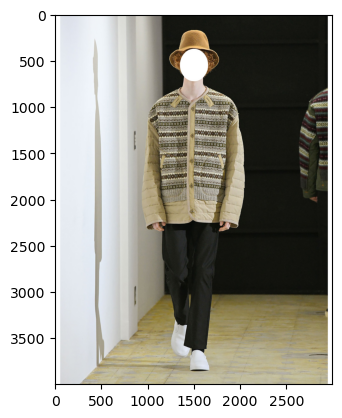

In [10]:
# 샘플 이미지
import matplotlib.pyplot as plt
a = plt.imread(train_image_path_temp + tdata.iloc[85238]['imgName']) #**
plt.imshow(a)
print(tdata_fc.iloc[85238])
print(tdata.iloc[85238])

In [11]:
# 라벨링 데이터프레임의 트레이닝, 테스트 데이터 세트 분할
X_train = tdata['imgName'] # 이미지 파일
y_train = tdata[["man","woman", "ivy","feminine","classic","mods","minimal","popart","space","hippie","disco","military","punk","bold","powersuit","bodyconscious","hiphop",
          "kitsch","lingerie","grunge","metrosexual","cityglam","oriental","ecology","sportivecasual","athleisure","lounge","normcore","genderless","1950","1960","1970","1980","1990","2000","2010","2020",
              "very_Good","good","bad","very_Bad", "spring_Autumn","summer","winter", "go_Work","date","official_Meeting","social_Gathering","daily","sports","travel","etc", "loose_Fit","normal_Fit","tight_Fit", "dark","bright",
              "cool","warm", "heavy","light", "not_stylish","stylish", "not_urban","urban", "not_trendy","trendy", "not_sophist","sophist",
              "not_neat","neat", "not_fancy","fancy", "not_unique","unique", "not_plain","plain", "not_open","open", "not_practical","practical",
              "not_active","active", "not_comfort","comfort", "not_lively","lively", "not_feminine","feminine", "not_masculine","masculine", "not_soft","soft"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [12]:
X_test = vdata['imgName'] # 이미지 파일
y_test = vdata[["man","woman", "ivy","feminine","classic","mods","minimal","popart","space","hippie","disco","military","punk","bold","powersuit","bodyconscious","hiphop",
          "kitsch","lingerie","grunge","metrosexual","cityglam","oriental","ecology","sportivecasual","athleisure","lounge","normcore","genderless","1950","1960","1970","1980","1990","2000","2010","2020",
              "very_Good","good","bad","very_Bad", "spring_Autumn","summer","winter", "go_Work","date","official_Meeting","social_Gathering","daily","sports","travel","etc", "loose_Fit","normal_Fit","tight_Fit", "dark","bright",
              "cool","warm", "heavy","light", "not_stylish","stylish", "not_urban","urban", "not_trendy","trendy", "not_sophist","sophist",
              "not_neat","neat", "not_fancy","fancy", "not_unique","unique", "not_plain","plain", "not_open","open", "not_practical","practical",
              "not_active","active", "not_comfort","comfort", "not_lively","lively", "not_feminine","feminine", "not_masculine","masculine", "not_soft","soft"]]

In [13]:
X_train = X_train.values.tolist()

In [15]:
X_train

['T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00003_19_normcore_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00007_19_normcore_M.jpg',
 'T_00008_19_normcore_M.jpg',
 'T_00009_10_sportivecasual_M.jpg',
 'T_00009_10_sportivecasual_M.jpg',
 'T_00010_19_normcore_M.jpg',
 'T_00011_19_normcore_M.jpg',
 'T_00012_19_normcore_M.jpg',
 'T_00014_19_normcore_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.

In [16]:
X_test = X_test.values.tolist()

In [17]:
X_test

['T_00017_19_normcore_M.jpg',
 'T_00031_10_sportivecasual_M.jpg',
 'T_00031_10_sportivecasual_M.jpg',
 'T_00035_19_normcore_M.jpg',
 'T_00037_10_sportivecasual_M.jpg',
 'T_00037_10_sportivecasual_M.jpg',
 'T_00042_10_sportivecasual_M.jpg',
 'T_00042_10_sportivecasual_M.jpg',
 'T_00054_19_normcore_M.jpg',
 'T_00063_10_sportivecasual_M.jpg',
 'T_00063_10_sportivecasual_M.jpg',
 'T_00066_10_sportivecasual_M.jpg',
 'T_00066_10_sportivecasual_M.jpg',
 'T_00070_10_sportivecasual_M.jpg',
 'T_00070_10_sportivecasual_M.jpg',
 'T_00074_19_normcore_M.jpg',
 'T_00081_10_sportivecasual_M.jpg',
 'T_00081_10_sportivecasual_M.jpg',
 'T_00088_10_sportivecasual_M.jpg',
 'T_00088_10_sportivecasual_M.jpg',
 'T_00090_19_normcore_M.jpg',
 'T_00115_10_sportivecasual_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00129_19_normcore_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00141_50_ivy_M.jpg',
 'T_00141_50_iv

In [18]:
y_train.columns

Index(['man', 'woman', 'ivy', 'feminine', 'classic', 'mods', 'minimal',
       'popart', 'space', 'hippie', 'disco', 'military', 'punk', 'bold',
       'powersuit', 'bodyconscious', 'hiphop', 'kitsch', 'lingerie', 'grunge',
       'metrosexual', 'cityglam', 'oriental', 'ecology', 'sportivecasual',
       'athleisure', 'lounge', 'normcore', 'genderless', '1950', '1960',
       '1970', '1980', '1990', '2000', '2010', '2020', 'very_Good', 'good',
       'bad', 'very_Bad', 'spring_Autumn', 'summer', 'winter', 'go_Work',
       'date', 'official_Meeting', 'social_Gathering', 'daily', 'sports',
       'travel', 'etc', 'loose_Fit', 'normal_Fit', 'tight_Fit', 'dark',
       'bright', 'cool', 'warm', 'heavy', 'light', 'not_stylish', 'stylish',
       'not_urban', 'urban', 'not_trendy', 'trendy', 'not_sophist', 'sophist',
       'not_neat', 'neat', 'not_fancy', 'fancy', 'not_unique', 'unique',
       'not_plain', 'plain', 'not_open', 'open', 'not_practical', 'practical',
       'not_active', 'ac

In [24]:
# @title
# Make Multi-task Training Set & Test Set
"""
각 Task에 맞게끔 트레이닝 셋 및 테스트 세트를 구성하기 위한 사전 준비 작업을 진행

구성되어 있는 Task들
Task 1 : 성별 구분 Task.
Task 2 : 스타일 구분 Task.
Task 3 : 연도 구분 Task.
Task 4 : 선호도 구분 Task.
Task 5 : 계절 구분 Task.
Task 6 : 상황 구분 Task.
Task 7 : 핏 구분 Task.
Task 8 : 색 밝기 구분 Task.
Task 9 : 색 온도 구분 Task.
Task 10 : 분위기 구분 Task.
Task 11 : 멋있음 구분 Task.
Task 12 : 도시적 구분 Task.
Task 13 : 트렌디 구분 Task.
Task 14 : 세련됨 구분 Task.
Task 15 : 깔끔함 구분 Task.
Task 16 : 화려함 구분 Task.
Task 17 : 독특함 구분 Task.
Task 18 : 무난함 구분 Task.
Task 19 : 개방적 구분 Task.
Task 20 : 실용적 구분 Task.
Task 21 : 활동적 구분 Task.
Task 22 : 편안함 구분 Task.
Task 23 : 발랄함 구분 Task.
Task 24 : 여성적 구분 Task.
Task 25 : 남성적 구분 Task.
Task 26 : 부드러움 구분 Task.

"""

# 이미지
# X_train = X_train.values.tolist()
# X_test = X_test.values.tolist()

# Task 1(성별)
gender = ['man', 'woman']
gender_train = y_train[gender]
gender_nodes = gender_train.shape[1]
gender_train = gender_train.values.tolist()

# Task 2(스타일)
styles = ["ivy","feminine","classic","mods","minimal","popart","space","hippie","disco","military","punk","bold","powersuit","bodyconscious","hiphop",
          "kitsch","lingerie","grunge","metrosexual","cityglam","oriental","ecology","sportivecasual","athleisure","lounge","normcore","genderless"]
styles_train = y_train[styles]
styles_nodes = styles_train.shape[1]
styles_train = styles_train.values.tolist()

# Task 3(연도)
years = ['1950','1960','1970','1980','1990','2000','2010','2020']
years_train = y_train[years]
years_nodes = years_train.shape[1]
years_train = years_train.values.tolist()

# Task 4(선호도)
scores = ['very_Good', 'good', 'bad', 'very_Bad']
scores_train = y_train[scores]
scores_nodes = scores_train.shape[1]
scores_train = scores_train.values.tolist()

# Task 5(계절)
season = ["spring_Autumn", "summer", "winter"]
season_train = y_train[season]
season_nodes = season_train.shape[1]
season_train = season_train.values.tolist()

# Task 6(상황)
tpo = ["go_Work", "date", "official_Meeting", "social_Gathering", "daily", "sports", "travel", "etc"]
tpo_train = y_train[tpo]
tpo_nodes = tpo_train.shape[1]
tpo_train = tpo_train.values.tolist()

# Task 7(핏)
fit = ["loose_Fit", "normal_Fit", "tight_Fit"]
fit_train = y_train[fit]
fit_nodes = fit_train.shape[1]
fit_train = fit_train.values.tolist()

# Task 8(색 밝기)
color_bright = ["dark", "bright"]
color_bright_train = y_train[color_bright]
color_bright_nodes = color_bright_train.shape[1]
color_bright_train = color_bright_train.values.tolist()

# Task 9(색 온도)
color_tempo = ["cool", "warm"]
color_tempo_train = y_train[color_tempo]
color_tempo_nodes = color_tempo_train.shape[1]
color_tempo_train = color_tempo_train.values.tolist()

# Task 10(분위기 구분)
mood = ["heavy", "light"]
mood_train = y_train[mood]
mood_nodes = mood_train.shape[1]
mood_train = mood_train.values.tolist()

# Task 11(멋있음 구분)
cool = ["not_stylish", "stylish"]
cool_train = y_train[cool]
cool_nodes = cool_train.shape[1]
cool_train = cool_train.values.tolist()

# Task 12(도시적 구분)
urban = ["not_urban", "urban"]
urban_train = y_train[urban]
urban_nodes = urban_train.shape[1]
urban_train = urban_train.values.tolist()

# Task 13(트렌디 구분)
trendy = ["not_trendy", "trendy"]
trendy_train = y_train[trendy]
trendy_nodes = trendy_train.shape[1]
trendy_train = trendy_train.values.tolist()

# Task 14(세련됨 구분)
sophist = ["not_sophist", "sophist"]
sophist_train = y_train[sophist]
sophist_nodes = sophist_train.shape[1]
sophist_train = sophist_train.values.tolist()

# Task 15(깔끔함 구분)
neat = ["not_neat", "neat"]
neat_train = y_train[neat]
neat_nodes = neat_train.shape[1]
neat_train = neat_train.values.tolist()

# Task 16(화려함 구분)
fancy = ["not_fancy", "fancy"]
fancy_train = y_train[fancy]
fancy_nodes = fancy_train.shape[1]
fancy_train = fancy_train.values.tolist()

# Task 17(독특함 구분)
uniques = ["not_unique", "unique"]
uniques_train = y_train[uniques]
uniques_nodes = uniques_train.shape[1]
uniques_train = uniques_train.values.tolist()

# Task 18(무난함 구분)
plain = ["not_plain", "plain"]
plain_train = y_train[plain]
plain_nodes = plain_train.shape[1]
plain_train = plain_train.values.tolist()

# Task 19(개방적 구분)
opens = ["not_open", "open"]
opens_train = y_train[opens]
opens_nodes = opens_train.shape[1]
opens_train = opens_train.values.tolist()

# Task 20(실용적 구분)
practical = ["not_practical", "practical"]
practical_train = y_train[practical]
practical_nodes = practical_train.shape[1]
practical_train = practical_train.values.tolist()

# Task 21(활동적 구분)
active = ["not_active", "active"]
active_train = y_train[active]
active_nodes = active_train.shape[1]
active_train = active_train.values.tolist()

# Task 22(편안함 구분)
comfort = ["not_comfort", "comfort"]
comfort_train = y_train[comfort]
comfort_nodes = comfort_train.shape[1]
comfort_train = comfort_train.values.tolist()

# Task 23(발랄함 구분)
lively = ["not_lively", "lively"]
lively_train = y_train[lively]
lively_nodes = lively_train.shape[1]
lively_train = lively_train.values.tolist()

# Task 24(여성적 구분)
feminine = ["not_feminine", "feminine"]
feminine_train = y_train[feminine]
feminine_nodes = feminine_train.shape[1]
feminine_train = feminine_train.values.tolist()

# Task 25(남성적 구분)
masculine = ["not_masculine", "masculine"]
masculine_train = y_train[masculine]
masculine_nodes = masculine_train.shape[1]
masculine_train = masculine_train.values.tolist()

# Task 26(부드러움 구분)
soft = ["not_soft", "soft"]
soft_train = y_train[soft]
soft_nodes = soft_train.shape[1]
soft_train = soft_train.values.tolist()

print(gender_nodes,styles_nodes,years_nodes,scores_nodes,season_nodes,tpo_nodes,fit_nodes,color_bright_nodes,color_tempo_nodes,mood_nodes,cool_nodes,urban_nodes,trendy_nodes,sophist_nodes,neat_nodes,fancy_nodes,uniques_nodes,plain_nodes,opens_nodes,practical_nodes,active_nodes,comfort_nodes,lively_nodes,feminine_nodes,masculine_nodes,soft_nodes)

# Test Set에 대해서도 똑같이 준비

# Task 1(성별)
gender = ['man', 'woman']
gender_test = y_test[gender]
gender_nodes = gender_test.shape[1]
gender_test = gender_test.values.tolist()

# Task 2(스타일)
styles = ["ivy","feminine","classic","mods","minimal","popart","space","hippie","disco","military","punk","bold","powersuit","bodyconscious","hiphop",
          "kitsch","lingerie","grunge","metrosexual","cityglam","oriental","ecology","sportivecasual","athleisure","lounge","normcore","genderless"]
styles_test = y_test[styles]
styles_nodes = styles_test.shape[1]
styles_test = styles_test.values.tolist()

# Task 3(연도)
years = ['1950','1960','1970','1980','1990','2000','2010','2020']
years_test = y_test[years]
years_nodes = years_test.shape[1]
years_test = years_test.values.tolist()

# Task 4(선호도)
scores = ['very_Good', 'good', 'bad', 'very_Bad']
scores_test = y_test[scores]
scores_nodes = scores_test.shape[1]
scores_test = scores_test.values.tolist()

# Task 5(계절)
season = ["spring_Autumn", "summer", "winter"]
season_test = y_test[season]
season_nodes = season_test.shape[1]
season_test = season_test.values.tolist()

# Task 6(상황)
tpo = ["go_Work", "date", "official_Meeting", "social_Gathering", "daily", "sports", "travel", "etc"]
tpo_test = y_test[tpo]
tpo_nodes = tpo_test.shape[1]
tpo_test = tpo_test.values.tolist()

# Task 7(핏)
fit = ["loose_Fit", "normal_Fit", "tight_Fit"]
fit_test = y_test[fit]
fit_nodes = fit_test.shape[1]
fit_test = fit_test.values.tolist()

# Task 8(색 밝기)
color_bright = ["dark", "bright"]
color_bright_test = y_test[color_bright]
color_bright_nodes = color_bright_test.shape[1]
color_bright_test = color_bright_test.values.tolist()

# Task 9(색 온도)
color_tempo = ["cool", "warm"]
color_tempo_test = y_test[color_tempo]
color_tempo_nodes = color_tempo_test.shape[1]
color_tempo_test = color_tempo_test.values.tolist()

# Task 10(분위기 구분)
mood = ["heavy", "light"]
mood_test = y_test[mood]
mood_nodes = mood_test.shape[1]
mood_test = mood_test.values.tolist()

# Task 11(멋있음 구분)
cool = ["not_stylish", "stylish"]
cool_test = y_test[cool]
cool_nodes = cool_test.shape[1]
cool_test = cool_test.values.tolist()

# Task 12(도시적 구분)
urban = ["not_urban", "urban"]
urban_test = y_test[urban]
urban_nodes = urban_test.shape[1]
urban_test = urban_test.values.tolist()

# Task 13(트렌디 구분)
trendy = ["not_trendy", "trendy"]
trendy_test = y_test[trendy]
trendy_nodes = trendy_test.shape[1]
trendy_test = trendy_test.values.tolist()

# Task 14(세련됨 구분)
sophist = ["not_sophist", "sophist"]
sophist_test = y_test[sophist]
sophist_nodes = sophist_test.shape[1]
sophist_test = sophist_test.values.tolist()

# Task 15(깔끔함 구분)
neat = ["not_neat", "neat"]
neat_test = y_test[neat]
neat_nodes = neat_test.shape[1]
neat_test = neat_test.values.tolist()

# Task 16(화려함 구분)
fancy = ["not_fancy", "fancy"]
fancy_test = y_test[fancy]
fancy_nodes = fancy_test.shape[1]
fancy_test = fancy_test.values.tolist()

# Task 17(독특함 구분)
uniques = ["not_unique", "unique"]
uniques_test = y_test[uniques]
uniques_nodes = uniques_test.shape[1]
uniques_test = uniques_test.values.tolist()

# Task 18(무난함 구분)
plain = ["not_plain", "plain"]
plain_test = y_test[plain]
plain_nodes = plain_test.shape[1]
plain_test = plain_test.values.tolist()

# Task 19(개방적 구분)
opens = ["not_open", "open"]
opens_test = y_test[opens]
opens_nodes = opens_test.shape[1]
opens_test = opens_test.values.tolist()

# Task 20(실용적 구분)
practical = ["not_practical", "practical"]
practical_test = y_test[practical]
practical_nodes = practical_test.shape[1]
practical_test = practical_test.values.tolist()

# Task 21(활동적 구분)
active = ["not_active", "active"]
active_test = y_test[active]
active_nodes = active_test.shape[1]
active_test = active_test.values.tolist()

# Task 22(편안함 구분)
comfort = ["not_comfort", "comfort"]
comfort_test = y_test[comfort]
comfort_nodes = comfort_test.shape[1]
comfort_test = comfort_test.values.tolist()

# Task 23(발랄함 구분)
lively = ["not_lively", "lively"]
lively_test = y_test[lively]
lively_nodes = lively_test.shape[1]
lively_test = lively_test.values.tolist()

# Task 24(여성적 구분)
feminine = ["not_feminine", "feminine"]
feminine_test = y_test[feminine]
feminine_nodes = feminine_test.shape[1]
feminine_test = feminine_test.values.tolist()

# Task 25(남성적 구분)
masculine = ["not_masculine", "masculine"]
masculine_test = y_test[masculine]
masculine_nodes = masculine_test.shape[1]
masculine_test = masculine_test.values.tolist()

# Task 26(부드러움 구분)
soft = ["not_soft", "soft"]
soft_test = y_test[soft]
soft_nodes = soft_test.shape[1]
soft_test = soft_test.values.tolist()

print(gender_nodes,styles_nodes,years_nodes,scores_nodes,season_nodes,tpo_nodes,fit_nodes,color_bright_nodes,color_tempo_nodes,mood_nodes,cool_nodes,urban_nodes,trendy_nodes,sophist_nodes,neat_nodes,fancy_nodes,uniques_nodes,plain_nodes,opens_nodes,practical_nodes,active_nodes,comfort_nodes,lively_nodes,feminine_nodes,masculine_nodes,soft_nodes)

2 28 8 4 3 8 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2
2 28 8 4 3 8 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2


In [25]:
X_train_temp = X_train
X_train_temp

['T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00001_50_ivy_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00002_90_hiphop_M.jpg',
 'T_00003_19_normcore_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00004_90_hiphop_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00005_80_bold_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00006_50_ivy_M.jpg',
 'T_00007_19_normcore_M.jpg',
 'T_00008_19_normcore_M.jpg',
 'T_00009_10_sportivecasual_M.jpg',
 'T_00009_10_sportivecasual_M.jpg',
 'T_00010_19_normcore_M.jpg',
 'T_00011_19_normcore_M.jpg',
 'T_00012_19_normcore_M.jpg',
 'T_00014_19_normcore_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00015_80_bold_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.jpg',
 'T_00016_50_ivy_M.

In [26]:
X_test_temp = X_test
X_test_temp

['T_00017_19_normcore_M.jpg',
 'T_00031_10_sportivecasual_M.jpg',
 'T_00031_10_sportivecasual_M.jpg',
 'T_00035_19_normcore_M.jpg',
 'T_00037_10_sportivecasual_M.jpg',
 'T_00037_10_sportivecasual_M.jpg',
 'T_00042_10_sportivecasual_M.jpg',
 'T_00042_10_sportivecasual_M.jpg',
 'T_00054_19_normcore_M.jpg',
 'T_00063_10_sportivecasual_M.jpg',
 'T_00063_10_sportivecasual_M.jpg',
 'T_00066_10_sportivecasual_M.jpg',
 'T_00066_10_sportivecasual_M.jpg',
 'T_00070_10_sportivecasual_M.jpg',
 'T_00070_10_sportivecasual_M.jpg',
 'T_00074_19_normcore_M.jpg',
 'T_00081_10_sportivecasual_M.jpg',
 'T_00081_10_sportivecasual_M.jpg',
 'T_00088_10_sportivecasual_M.jpg',
 'T_00088_10_sportivecasual_M.jpg',
 'T_00090_19_normcore_M.jpg',
 'T_00115_10_sportivecasual_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00123_90_hiphop_M.jpg',
 'T_00129_19_normcore_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00134_90_hiphop_M.jpg',
 'T_00141_50_ivy_M.jpg',
 'T_00141_50_iv

In [27]:
import tensorflow as tf
import numpy as np

# initialize the number of epochs and batch size
EPOCHS = 50
BS = 16

# image_generator_fgo라는 함수를 통해 전처리를 진행합니다.
"""
이미지와 각 레이블을 담을 리스트를 준비한 후,
"""

# 훈련용이미지
def image_generator_fgo_t_temp(cloth_lists, bs, mode="train", aug=None):
    # loop indefinitely

    while True:
        # 이미지와 각 레이블을 담을 리스트
        images = []
        gender = []
        styles = []
        years = []
        scores = []
        season = []
        tpo = []
        fit = []
        color_bright = []
        color_tempo = []
        mood = []
        cool = []
        urban = []
        trendy = []
        sophist = []
        neat = []
        fancy = []
        uniques = []
        plain = []
        opens = []
        practical = []
        active = []
        comfort = []
        lively = []
        feminine = []
        masculine = []
        soft = []

        # 이미지의 수가 배치 사이즈보다 작을 동안 루프문을 진행
        while len(images) < bs:
            combined_label_list = []

            # 랜덤하게 이미지를 뽑아서, 관련된 Task의 레이블들과 리스트로 적재하는 구문
            # 랜덤 이미지 로드
            random_index = randrange(len(cloth_lists[0]))
            img = image.load_img(train_image_path_temp + cloth_lists[0][random_index],target_size=(224, 224)) #read in image
            img = image.img_to_array(img)
            # img = cv2.resize(img, (224, 224))
            # rand = random.randint(1,101)
            # if rand < 50:
            #    img = cv2.flip( img, 0 )# horizantal flip
            # rand = random.randint(1,101)
            # img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            # 이미지와 관련 Task들의 레이블 append
            gender.append(np.array(cloth_lists[1][random_index]))
            styles.append(np.array(cloth_lists[2][random_index]))
            years.append(np.array(cloth_lists[3][random_index]))
            scores.append(np.array(cloth_lists[4][random_index]))
            season.append(np.array(cloth_lists[5][random_index]))
            tpo.append(np.array(cloth_lists[6][random_index]))
            fit.append(np.array(cloth_lists[7][random_index]))
            color_bright.append(np.array(cloth_lists[8][random_index]))
            color_tempo.append(np.array(cloth_lists[9][random_index]))
            mood.append(np.array(cloth_lists[10][random_index]))
            cool.append(np.array(cloth_lists[11][random_index]))
            urban.append(np.array(cloth_lists[12][random_index]))
            trendy.append(np.array(cloth_lists[13][random_index]))
            sophist.append(np.array(cloth_lists[14][random_index]))
            neat.append(np.array(cloth_lists[15][random_index]))
            fancy.append(np.array(cloth_lists[16][random_index]))
            uniques.append(np.array(cloth_lists[17][random_index]))
            plain.append(np.array(cloth_lists[18][random_index]))
            opens.append(np.array(cloth_lists[19][random_index]))
            practical.append(np.array(cloth_lists[20][random_index]))
            active.append(np.array(cloth_lists[21][random_index]))
            comfort.append(np.array(cloth_lists[22][random_index]))
            lively.append(np.array(cloth_lists[23][random_index]))
            feminine.append(np.array(cloth_lists[24][random_index]))
            masculine.append(np.array(cloth_lists[25][random_index]))
            soft.append(np.array(cloth_lists[26][random_index]))

            images.append(img) # image

        # 최종 리스트 저장
        labels = [np.array(gender),np.array(styles),np.array(years),np.array(scores), np.array(season),np.array(tpo),
                  np.array(fit),np.array(color_bright),np.array(color_tempo),np.array(mood),np.array(cool),np.array(urban),
                  np.array(trendy),np.array(sophist),np.array(neat),np.array(fancy),np.array(uniques),np.array(plain),
                  np.array(opens),np.array(practical),np.array(active),np.array(comfort),np.array(lively),np.array(feminine),
                  np.array(masculine),np.array(soft)]

        # aug는 밖에서 ImageDataGenerator를 불러오는 파라미터로 사용합니다. 다만 뒤의 함수에서 None으로 지정
        if aug is not None:
          try:
             (images, labels) = next(aug.flow(np.array(images),labels, batch_size=bs))
          except StopIteration as exc:
            pass


        # 이터레이터
        yield np.array(images), labels
        """
        yield는 제너레이터에 사용되는 키워드로,
        반복문과 사용하는 return 구문이라고 볼 수 있습니다.
        """

# 테스트용 이미지
def image_generator_fgo_v_temp(cloth_lists, bs, mode="train", aug=None):
    # loop indefinitely

    while True:
        # 이미지와 각 레이블을 담을 리스트
        images = []
        gender = []
        styles = []
        years = []
        scores = []
        season = []
        tpo = []
        fit = []
        color_bright = []
        color_tempo = []
        mood = []
        cool = []
        urban = []
        trendy = []
        sophist = []
        neat = []
        fancy = []
        uniques = []
        plain = []
        opens = []
        practical = []
        active = []
        comfort = []
        lively = []
        feminine = []
        masculine = []
        soft = []

        # 이미지의 수가 배치 사이즈보다 작을 동안 루프문을 진행
        while len(images) < bs:
            combined_label_list = []

            # 랜덤하게 이미지를 뽑아서, 관련된 Task의 레이블들과 리스트로 적재하는 구문
            # 랜덤 이미지 로드
            random_index = randrange(len(cloth_lists[0]))
            img = image.load_img(test_image_path_temp + cloth_lists[0][random_index],target_size=(224, 224)) #read in image
            img = image.img_to_array(img)
            # img = cv2.resize(img, (224, 224))
            # rand = random.randint(1,101)
            # if rand < 50:
            #    img = cv2.flip( img, 0 )# horizantal flip
            # rand = random.randint(1,101)
            # img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            # 이미지와 관련 Task들의 레이블 append
            gender.append(np.array(cloth_lists[1][random_index]))
            styles.append(np.array(cloth_lists[2][random_index]))
            years.append(np.array(cloth_lists[3][random_index]))
            scores.append(np.array(cloth_lists[4][random_index]))
            season.append(np.array(cloth_lists[5][random_index]))
            tpo.append(np.array(cloth_lists[6][random_index]))
            fit.append(np.array(cloth_lists[7][random_index]))
            color_bright.append(np.array(cloth_lists[8][random_index]))
            color_tempo.append(np.array(cloth_lists[9][random_index]))
            mood.append(np.array(cloth_lists[10][random_index]))
            cool.append(np.array(cloth_lists[11][random_index]))
            urban.append(np.array(cloth_lists[12][random_index]))
            trendy.append(np.array(cloth_lists[13][random_index]))
            sophist.append(np.array(cloth_lists[14][random_index]))
            neat.append(np.array(cloth_lists[15][random_index]))
            fancy.append(np.array(cloth_lists[16][random_index]))
            uniques.append(np.array(cloth_lists[17][random_index]))
            plain.append(np.array(cloth_lists[18][random_index]))
            opens.append(np.array(cloth_lists[19][random_index]))
            practical.append(np.array(cloth_lists[20][random_index]))
            active.append(np.array(cloth_lists[21][random_index]))
            comfort.append(np.array(cloth_lists[22][random_index]))
            lively.append(np.array(cloth_lists[23][random_index]))
            feminine.append(np.array(cloth_lists[24][random_index]))
            masculine.append(np.array(cloth_lists[25][random_index]))
            soft.append(np.array(cloth_lists[26][random_index]))

            images.append(img) # image

        # 최종 리스트 저장
        labels = [np.array(gender),np.array(styles),np.array(years),np.array(scores), np.array(season),np.array(tpo),
                  np.array(fit),np.array(color_bright),np.array(color_tempo),np.array(mood),np.array(cool),np.array(urban),
                  np.array(trendy),np.array(sophist),np.array(neat),np.array(fancy),np.array(uniques),np.array(plain),
                  np.array(opens),np.array(practical),np.array(active),np.array(comfort),np.array(lively),np.array(feminine),
                  np.array(masculine),np.array(soft)]

        # aug는 밖에서 ImageDataGenerator를 불러오는 파라미터로 사용합니다. 다만 뒤의 함수에서 None으로 지정
        if aug is not None:
          try:
             (images, labels) = next(aug.flow(np.array(images),labels, batch_size=bs))
          except StopIteration as exc:
            pass


        # 이터레이터
        yield np.array(images), labels
        """
        yield는 제너레이터에 사용되는 키워드로,
        반복문과 사용하는 return 구문이라고 볼 수 있습니다.
        """

# 함수에 사용되는 이미지 제너레이터 부분
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# 함수에 넣기 위해 이미지Path, 각 레이블Path를 리스트화
train_lists_temp = [X_train_temp, gender_train, styles_train, years_train, scores_train, season_train, tpo_train, fit_train,
               color_bright_train, color_tempo_train, mood_train, cool_train, urban_train, trendy_train, sophist_train,
               neat_train, fancy_train, uniques_train, plain_train, opens_train, practical_train, active_train, comfort_train,
               lively_train, feminine_train, masculine_train, soft_train]
test_lists_temp = [X_test_temp, gender_test, styles_test, years_test, scores_test, season_test, tpo_test, fit_test,
               color_bright_test, color_tempo_test, mood_test, cool_test, urban_test, trendy_test, sophist_test,
               neat_test, fancy_test, uniques_test, plain_test, opens_test, practical_test, active_test, comfort_test,
               lively_test, feminine_test, masculine_test, soft_test]

# Train, Test set에 대해 함수 실행
trainGenTemp = image_generator_fgo_t_temp(train_lists_temp, BS, mode="train", aug=None)
testGenTemp = image_generator_fgo_v_temp(test_lists_temp, BS, mode="train", aug=None)

In [24]:
# Color Images, Multi-Label Targets
from tensorflow.keras.optimizers import SGD, Adam

# Loss, Metric 설정
loss_list = ['binary_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
             'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','binary_crossentropy',
             'binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy',
             'binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy',
             'binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy',
             'binary_crossentropy','binary_crossentropy','binary_crossentropy']

test_metrics = {'gender':'accuracy','styles':'accuracy','years':'accuracy','scores':'accuracy','season':'accuracy','tpo':'accuracy',
                'fit':'accuracy','color_bright':'accuracy','color_tempo':'accuracy','mood':'accuracy','cool':'accuracy','urban':'accuracy',
                'trendy':'accuracy','sophist':'accuracy','neat':'accuracy','fancy':'accuracy','uniques':'accuracy','plain':'accuracy',
                'opens':'accuracy','practical':'accuracy','active':'accuracy','comfort':'accuracy','lively':'accuracy','feminine':'accuracy',
                'masculine':'accuracy','soft':'accuracy'}

dd = 0.0 # Dropout 부분
import math

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

# Multi-task 모델 구현부
"""
Shared layer(컨볼루전 망)에 대해서는 VGG19를 전이학습하여 사용하고(가중치 업데이트 freeze),
이후 GAP를 적용한 값들에 대해 Task별로 별도의 레이어를 구성하는 방식으로 구현.
"""
def multi_model(loss_list,test_metrics,dd):

    # 모든 Task들이 공유하는 컨볼루전망
    # VGG19 전이학습 수행
    base_model = VGG19(weights='imagenet', include_top=False)

    # VGG19의 가중치 업데이트 freeze
    for layer in base_model.layers[:]:
       layer.trainable = False

    # 이미지 input 및 Shared parameter 부분
    model_input = Input(shape=(224, 224, 3))
    x = base_model(model_input) # VGG19
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dd)(x)

    # Task 1의 Layer
    y1 = Dense(128, activation='relu')(x)
    y1 = Dropout(dd)(y1)
    y1 = Dense(64, activation='relu')(y1)
    y1 = Dropout(dd)(y1)

    # Task 2의 Layer
    y2 = Dense(128, activation='relu')(x)
    y2 = Dropout(dd)(y2)
    y2 = Dense(64, activation='relu')(y2)
    y2 = Dropout(dd)(y2)

    # Task 3의 Layer
    y3 = Dense(128, activation='relu')(x)
    y3 = Dropout(dd)(y3)
    y3 = Dense(64, activation='relu')(y3)
    y3 = Dropout(dd)(y3)

    # Task 4의 Layer
    y4 = Dense(128, activation='relu')(x)
    y4 = Dropout(dd)(y4)
    y4 = Dense(64, activation='relu')(y4)
    y4 = Dropout(dd)(y4)

    # Task 5의 Layer
    y5 = Dense(128, activation='relu')(x)
    y5 = Dropout(dd)(y5)
    y5 = Dense(64, activation='relu')(y5)
    y5 = Dropout(dd)(y5)

    # Task 6의 Layer
    y6 = Dense(128, activation='relu')(x)
    y6 = Dropout(dd)(y6)
    y6 = Dense(64, activation='relu')(y6)
    y6 = Dropout(dd)(y6)

    # Task 7의 Layer
    y7 = Dense(128, activation='relu')(x)
    y7 = Dropout(dd)(y7)
    y7 = Dense(64, activation='relu')(y7)
    y7 = Dropout(dd)(y7)

    # Task 8의 Layer
    y8 = Dense(128, activation='relu')(x)
    y8 = Dropout(dd)(y8)
    y8 = Dense(64, activation='relu')(y8)
    y8 = Dropout(dd)(y8)

    # Task 9의 Layer
    y9 = Dense(128, activation='relu')(x)
    y9 = Dropout(dd)(y9)
    y9 = Dense(64, activation='relu')(y9)
    y9 = Dropout(dd)(y9)

    # Task 10의 Layer
    y10 = Dense(128, activation='relu')(x)
    y10 = Dropout(dd)(y10)
    y10 = Dense(64, activation='relu')(y10)
    y10 = Dropout(dd)(y10)

    # Task 11의 Layer
    y11 = Dense(128, activation='relu')(x)
    y11 = Dropout(dd)(y11)
    y11 = Dense(64, activation='relu')(y11)
    y11 = Dropout(dd)(y11)

    # Task 12의 Layer
    y12 = Dense(128, activation='relu')(x)
    y12 = Dropout(dd)(y12)
    y12 = Dense(64, activation='relu')(y12)
    y12 = Dropout(dd)(y12)

    # Task 13의 Layer
    y13 = Dense(128, activation='relu')(x)
    y13 = Dropout(dd)(y13)
    y13 = Dense(64, activation='relu')(y13)
    y13 = Dropout(dd)(y13)

    # Task 14의 Layer
    y14 = Dense(128, activation='relu')(x)
    y14 = Dropout(dd)(y14)
    y14 = Dense(64, activation='relu')(y14)
    y14 = Dropout(dd)(y14)

    # Task 15의 Layer
    y15 = Dense(128, activation='relu')(x)
    y15 = Dropout(dd)(y15)
    y15 = Dense(64, activation='relu')(y15)
    y15 = Dropout(dd)(y15)

    # Task 16의 Layer
    y16 = Dense(128, activation='relu')(x)
    y16 = Dropout(dd)(y16)
    y16 = Dense(64, activation='relu')(y16)
    y16 = Dropout(dd)(y16)

    # Task 17의 Layer
    y17 = Dense(128, activation='relu')(x)
    y17 = Dropout(dd)(y17)
    y17 = Dense(64, activation='relu')(y17)
    y17 = Dropout(dd)(y17)

    # Task 18의 Layer
    y18 = Dense(128, activation='relu')(x)
    y18 = Dropout(dd)(y18)
    y18 = Dense(64, activation='relu')(y18)
    y18 = Dropout(dd)(y18)

    # Task 19의 Layer
    y19 = Dense(128, activation='relu')(x)
    y19 = Dropout(dd)(y19)
    y19 = Dense(64, activation='relu')(y19)
    y19 = Dropout(dd)(y19)

    # Task 20의 Layer
    y20 = Dense(128, activation='relu')(x)
    y20 = Dropout(dd)(y20)
    y20 = Dense(64, activation='relu')(y20)
    y20 = Dropout(dd)(y20)

    # Task 21의 Layer
    y21 = Dense(128, activation='relu')(x)
    y21 = Dropout(dd)(y21)
    y21 = Dense(64, activation='relu')(y21)
    y21 = Dropout(dd)(y21)

    # Task 22의 Layer
    y22 = Dense(128, activation='relu')(x)
    y22 = Dropout(dd)(y22)
    y22 = Dense(64, activation='relu')(y22)
    y22 = Dropout(dd)(y22)

    # Task 23의 Layer
    y23 = Dense(128, activation='relu')(x)
    y23 = Dropout(dd)(y23)
    y23 = Dense(64, activation='relu')(y23)
    y23 = Dropout(dd)(y23)

    # Task 24의 Layer
    y24 = Dense(128, activation='relu')(x)
    y24 = Dropout(dd)(y24)
    y24 = Dense(64, activation='relu')(y24)
    y24 = Dropout(dd)(y24)

    # Task 25의 Layer
    y25 = Dense(128, activation='relu')(x)
    y25 = Dropout(dd)(y25)
    y25 = Dense(64, activation='relu')(y25)
    y25 = Dropout(dd)(y25)

    # Task 26의 Layer
    y26 = Dense(128, activation='relu')(x)
    y26 = Dropout(dd)(y26)
    y26 = Dense(64, activation='relu')(y26)
    y26 = Dropout(dd)(y26)

    # 각 Task별 최종 Dense 연결
    y1 = Dense(gender_nodes, activation='sigmoid',name= 'gender')(y1)
    y2 = Dense(styles_nodes, activation='softmax',name= 'styles')(y2)
    y3 = Dense(years_nodes, activation='softmax',name= 'years')(y3)
    y4 = Dense(scores_nodes, activation='softmax',name= 'scores')(y4)
    y5 = Dense(season_nodes, activation='softmax',name= 'season')(y5)
    y6 = Dense(tpo_nodes, activation='softmax',name= 'tpo')(y6)
    y7 = Dense(fit_nodes, activation='softmax',name= 'fit')(y7)
    y8 = Dense(color_bright_nodes, activation='sigmoid',name= 'color_bright')(y8)
    y9 = Dense(color_tempo_nodes, activation='sigmoid',name= 'color_tempo')(y9)
    y10 = Dense(mood_nodes, activation='sigmoid',name= 'mood')(y10)
    y11 = Dense(cool_nodes, activation='sigmoid',name= 'cool')(y11)
    y12 = Dense(urban_nodes, activation='sigmoid',name= 'urban')(y12)
    y13 = Dense(trendy_nodes, activation='sigmoid',name= 'trendy')(y13)
    y14 = Dense(sophist_nodes, activation='sigmoid',name= 'sophist')(y14)
    y15 = Dense(neat_nodes, activation='sigmoid',name= 'neat')(y15)
    y16 = Dense(fancy_nodes, activation='sigmoid',name= 'fancy')(y16)
    y17 = Dense(uniques_nodes, activation='sigmoid',name= 'uniques')(y17)
    y18 = Dense(plain_nodes, activation='sigmoid',name= 'plain')(y18)
    y19 = Dense(opens_nodes, activation='sigmoid',name= 'opens')(y19)
    y20 = Dense(practical_nodes, activation='sigmoid',name= 'practical')(y20)
    y21 = Dense(active_nodes, activation='sigmoid',name= 'active')(y21)
    y22 = Dense(comfort_nodes, activation='sigmoid',name= 'comfort')(y22)
    y23 = Dense(lively_nodes, activation='sigmoid',name= 'lively')(y23)
    y24 = Dense(feminine_nodes, activation='sigmoid',name= 'feminine')(y24)
    y25 = Dense(masculine_nodes, activation='sigmoid',name= 'masculine')(y25)
    y26 = Dense(soft_nodes, activation='sigmoid',name= 'soft')(y26)


    # 공유 파라미터와 각 Task 연결
    model = Model(inputs=model_input, outputs=[y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26])

    # 컴파일러 부분
    model.compile(loss=loss_list, optimizer=SGD(lr=0.01, momentum=0.9), metrics=test_metrics)

    return model

multi_model = multi_model(loss_list,test_metrics,dd)
multi_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, None, None, 512)      2002438   ['input_2[0][0]']             
                                                          4                                       
                                                                                                  
 global_average_pooling2d (  (None, 512)                  0         ['vgg19[0][0]']               
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [28]:
print(multi_model.metrics_names)


['loss', 'gender_loss', 'styles_loss', 'years_loss', 'scores_loss', 'season_loss', 'tpo_loss', 'fit_loss', 'color_bright_loss', 'color_tempo_loss', 'mood_loss', 'cool_loss', 'urban_loss', 'trendy_loss', 'sophist_loss', 'neat_loss', 'fancy_loss', 'uniques_loss', 'plain_loss', 'opens_loss', 'practical_loss', 'active_loss', 'comfort_loss', 'lively_loss', 'feminine_loss', 'masculine_loss', 'soft_loss', 'gender_accuracy', 'styles_accuracy', 'years_accuracy', 'scores_accuracy', 'season_accuracy', 'tpo_accuracy', 'fit_accuracy', 'color_bright_accuracy', 'color_tempo_accuracy', 'mood_accuracy', 'cool_accuracy', 'urban_accuracy', 'trendy_accuracy', 'sophist_accuracy', 'neat_accuracy', 'fancy_accuracy', 'uniques_accuracy', 'plain_accuracy', 'opens_accuracy', 'practical_accuracy', 'active_accuracy', 'comfort_accuracy', 'lively_accuracy', 'feminine_accuracy', 'masculine_accuracy', 'soft_accuracy']


In [31]:
len(X_train_temp)//256

825

In [32]:
len(X_test_temp)//256

142

In [ ]:
import os

img_folder_path = "/content/drive/MyDrive/Project/data/Training/images"
img_file_list = os.listdir(img_folder_path)
img_file_count = len(img_file_list)
print(img_file_count)

85239


In [ ]:
import os

img_folder_path = "/content/drive/MyDrive/Project/data/Training/images_temp"
img_file_list = os.listdir(img_folder_path)
img_file_count = len(img_file_list)
print(img_file_count)

96


In [39]:
trainGenTemp = image_generator_fgo_t_temp(
    train_lists_temp,
    32,
    mode='categorical'
)
# image_generator_fgo_t_temp(train_lists_temp, BS, mode="train", aug=None)

testGenTemp = image_generator_fgo_v_temp(
    test_lists_temp,
    32,
    mode='categorical',
    # shuffle=False  # 테스트 데이터는 셔플하지 않도록 설정
)

In [40]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/Project/data/model/best_run5_smaller.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
multi_model = tf.keras.models.load_model('C:/data_warehouse/Project/data/model/best_20231116101229.h5')
# 모델을 저장하기 위한 폴더
model_dir = "E:/data_warehouse/Project/data/model/"

# 폴더가 없다면 생성
# if not os.path.exists(model_dir) :
#   os.mkdir(model_dir)

# 저장할 파일명 설정
# epoch:03d : epoch 값을 정수형(d) 세자리(03) 값으로 출력
# val_accuracy:,3f : val_accuracy 값을 실수형(f) 소수점 3째자리(.3)까지 출력
# 파일명 예시 : best_010_0.83_0.02.hdf5
file_path = model_dir + 'best_' + datetime.today().strftime("%Y%m%d%H%M%S") +'.h5'

# filepath : 저장할 파일명
# monitor : 베스트모델 판단 기준
# save_best_only : True이면 더 나은 모델만 저장, False이면 전부 다 저장
checkpoint = ModelCheckpoint(filepath = file_path, monitor = "val_accuracy", save_best_only=False)

# monitor : 학습중단 기준 (베스트모델의 판단 기준과 동일하게 설정)
# patience : 더 나은 모델이 아니더라도 몇 epoch를 더 대기할 것인지 설정
# es = EarlyStopping(monitor = "val_accuracy", patience=10)

try:
    h = multi_model.fit(
        trainGenTemp,
        epochs=50,
        batch_size=32,
        steps_per_epoch=len(X_train)//512,
        validation_data=testGenTemp,
        validation_steps=len(X_test)//512,
        callbacks=[checkpoint]
    )
except StopIteration:
    pass

Epoch 1/50
412/412 [==============================] - 16130s 39s/step - loss: 22.1527 - gender_loss: 0.4372 - styles_loss: 4.1942 - years_loss: 2.0769 - scores_loss: 1.2937 - season_loss: 0.9950 - tpo_loss: 1.9121 - fit_loss: 0.9587 - color_bright_loss: 0.6633 - color_tempo_loss: 0.6855 - mood_loss: 0.6501 - cool_loss: 0.4668 - urban_loss: 0.6018 - trendy_loss: 0.6087 - sophist_loss: 0.5920 - neat_loss: 0.5664 - fancy_loss: 0.5242 - uniques_loss: 0.6265 - plain_loss: 0.5389 - opens_loss: 0.4893 - practical_loss: 0.4943 - active_loss: 0.5749 - comfort_loss: 0.5687 - lively_loss: 0.4996 - feminine_loss: 0.5178 - masculine_loss: 0.2927 - soft_loss: 0.3236 - gender_accuracy: 0.7985 - styles_accuracy: 0.2108 - years_accuracy: 0.1418 - scores_accuracy: 0.3195 - season_accuracy: 0.5536 - tpo_accuracy: 0.2753 - fit_accuracy: 0.5693 - color_bright_accuracy: 0.5998 - color_tempo_accuracy: 0.5627 - mood_accuracy: 0.6460 - cool_accuracy: 0.8230 - urban_accuracy: 0.7105 - trendy_accuracy: 0.7028 - 

KeyboardInterrupt: 